# Workshop 1: Autoencoder อย่างง่าย

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [2]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


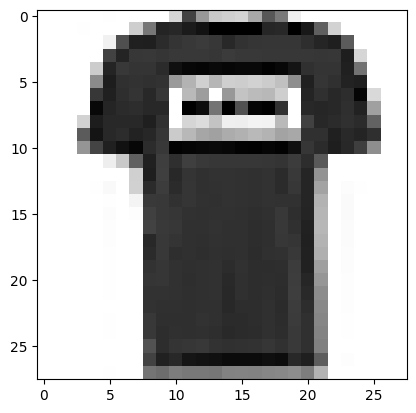

In [3]:
plt.imshow(X_train[1], cmap=plt.cm.gray_r)
plt.show()

## เตรียมข้อมูล

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## สร้าง Model

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras import Model, Sequential

In [6]:
encoding_dim = 36

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.encoding_dim = encoding_dim

    self.encoder = Sequential([
        Flatten(),
        Dense(encoding_dim, activation='relu')
    ])

    self.decoder = Sequential([
        Dense(784, activation='sigmoid'),
        Reshape((28, 28))
    ])
  def call(self, x):
    encoded = self.encoder(x)

    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(encoding_dim)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, validation_data=(X_test, X_test))

Epoch 1/20
235/235 [==============================] - 6s 5ms/step - loss: 0.4147 - val_loss: 0.3419
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.3265 - val_loss: 0.3189
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.3103 - val_loss: 0.3068
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.3004 - val_loss: 0.2992
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2940 - val_loss: 0.2937
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2899 - val_loss: 0.2906
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2874 - val_loss: 0.2888
Epoch 8/20
235/235 [==============================] - 1s 6ms/step - loss: 0.2858 - val_loss: 0.2876
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2848 - val_loss: 0.2867
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2840 - val_loss: 0.2863

In [7]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 36)                28260     
                                                                 
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               29008     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 29,008
Trainable params: 29,008
Non-trainable params: 0
_________________________________________________________________


## ทดสอบ

In [9]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
print(encoded_imgs.shape)

(10000, 36)


In [10]:
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

(10000, 28, 28)


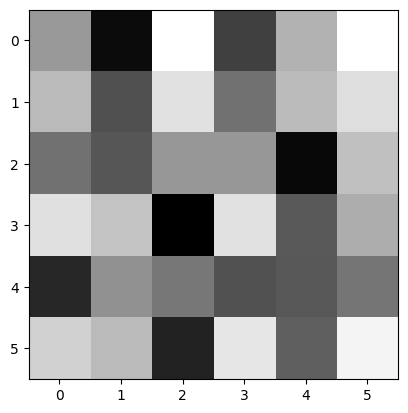

In [11]:
plt.imshow(encoded_imgs[0].reshape(6, 6), cmap=plt.cm.gray_r)

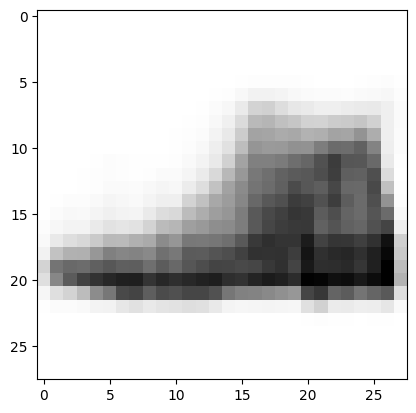

In [12]:
plt.imshow(decoded_imgs[0], cmap=plt.cm.gray_r)

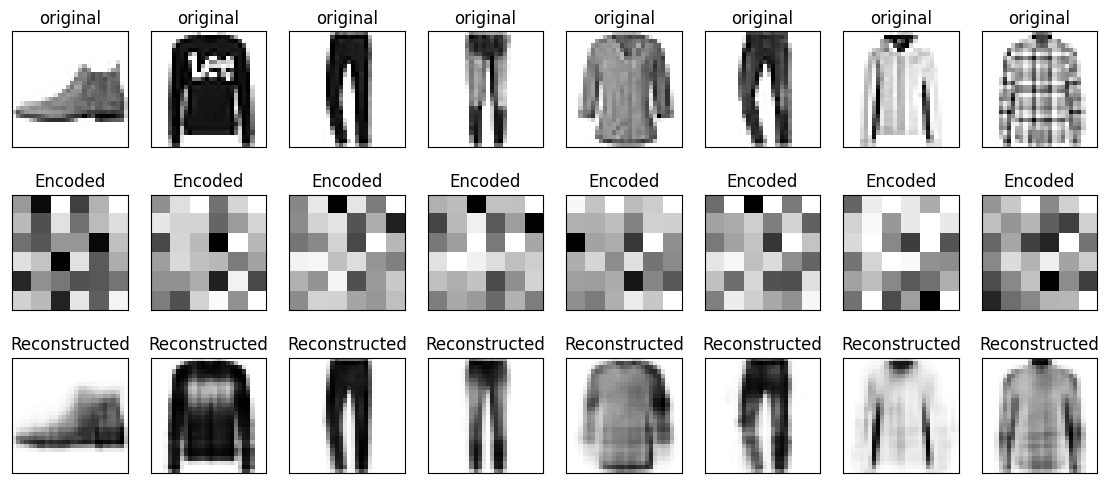

In [13]:
n = 8
plt.figure(figsize=(14, 6))
for i in range(n):

  ax = plt.subplot(3, n, i + 1)
  plt.title("original")
  plt.imshow(X_test[i], cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

  bx = plt.subplot(3, n, n + i + 1)
  plt.title("Encoded")
  plt.imshow(encoded_imgs[i].reshape(6, 6), cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

  cx = plt.subplot(3, n, 2*n + i + 1)
  plt.title("Reconstructed")
  plt.imshow(decoded_imgs[i], cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

plt.show()

# Workshop 2: Autoencoder ลด Noise

## เตรียมข้อมูล

In [14]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()
print(X_train.shape)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


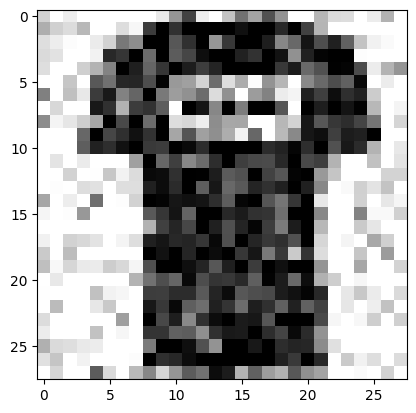

In [15]:
nosise_factor = 0.2
X_train_noisy = X_train + nosise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + nosise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

img = X_train_noisy[1]
plt.imshow(img, cmap=plt.cm.gray_r)
plt.show()

## สร้าง Model

In [16]:
from tensorflow.keras.layers import InputLayer, Conv2D, Conv2DTranspose

In [17]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
    ])

    self.decoder = Sequential([
        Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_noisy, X_train, epochs=10, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/10
469/469 [==============================] - 10s 6ms/step - loss: 0.3395 - val_loss: 0.2928
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2841 - val_loss: 0.2866
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2796 - val_loss: 0.2831
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2764 - val_loss: 0.2791
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2745 - val_loss: 0.2793
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2733 - val_loss: 0.2779
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2724 - val_loss: 0.2741
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2717 - val_loss: 0.2740
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2710 - val_loss: 0.2728
Epoch 10/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2703 - val_loss: 0.270

## ใช้งาน

In [18]:
encoded_imgs = autoencoder.encoder(X_test_noisy).numpy()
print(encoded_imgs.shape)

(10000, 7, 7, 8)


In [19]:
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

(10000, 28, 28, 1)


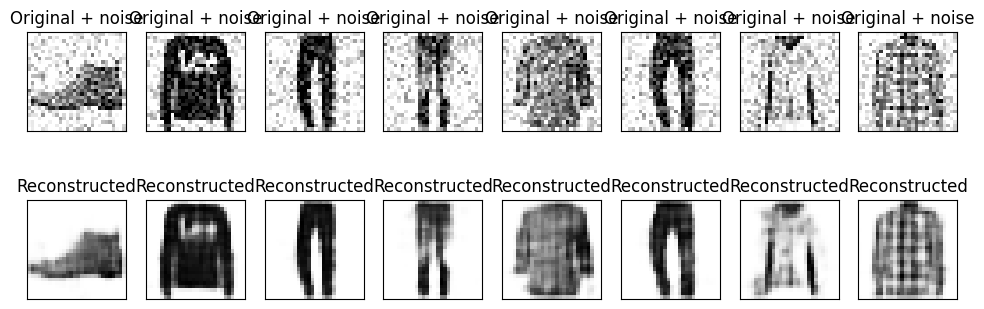

In [20]:
n = 8
plt.figure(figsize=(12, 4))
for i in range(n):

  ax = plt.subplot(2, n, i + 1)
  plt.title("Original + noise")
  plt.imshow(np.squeeze(X_test_noisy[i]), cmap=plt.cm.gray_r)
  plt.imshow(X_test_noisy[i], cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

  bx = plt.subplot(2, n, n + i + 1)
  plt.title("Reconstructed")
  plt.imshow(np.squeeze(decoded_imgs[i]), cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

plt.show()

# Workshop 3: ลด Noise พื้นหลังข้อความ

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!unzip "/content/drive/MyDrive/Colab Notebooks/train.zip" -d "/content/train"
!unzip "/content/drive/MyDrive/Colab Notebooks/test.zip" -d "/content/test"
!unzip "/content/drive/MyDrive/Colab Notebooks/train_cleaned.zip" -d "/content/train_cleaned"

Archive:  /content/drive/MyDrive/Colab Notebooks/train.zip
   creating: /content/train/train/
  inflating: /content/train/train/101.png  
  inflating: /content/train/train/102.png  
  inflating: /content/train/train/104.png  
  inflating: /content/train/train/105.png  
 extracting: /content/train/train/107.png  
 extracting: /content/train/train/108.png  
 extracting: /content/train/train/11.png  
  inflating: /content/train/train/110.png  
 extracting: /content/train/train/111.png  
  inflating: /content/train/train/113.png  
  inflating: /content/train/train/114.png  
 extracting: /content/train/train/116.png  
  inflating: /content/train/train/117.png  
 extracting: /content/train/train/119.png  
 extracting: /content/train/train/12.png  
 extracting: /content/train/train/120.png  
  inflating: /content/train/train/122.png  
 extracting: /content/train/train/123.png  
  inflating: /content/train/train/125.png  
  inflating: /content/train/train/126.png  
  inflating: /content/train/

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
imgW, imgH = 540, 420
train_img = sorted(os.listdir("/content/train/train"))
train_cleaned_img = sorted(os.listdir("/content/train_cleaned/train_cleaned"))
test_img = sorted(os.listdir("/content/test/test"))

print(f'X Train: {len(train_img)} , Y Train: {len(train_cleaned_img)}')
print('X Test:', len(test_img))

X Train: 144 , Y Train: 144
X Test: 72


## เตรียมข้อมูลเบื้องต้น (Preprocess)

In [26]:
def process_image(file):
  img = load_img(file, target_size=(imgH, imgW), color_mode='grayscale')
  img = img_to_array(img)
  img = img / 255.0
  return img

In [27]:
train = []
train_cleaned = []
test = []

for f in tqdm(train_img):
  train.append(process_image("/content/train/train/" + f))

for f in tqdm(train_cleaned_img):
  train_cleaned.append(process_image("/content/train_cleaned/train_cleaned/" + f))

for f in tqdm(test_img):
  test.append(process_image("/content/test/test/" + f))

print('\nTrain0 shape:', train[0].shape)

100%|██████████| 72/72 [00:00<00:00, 180.11it/s]


Train0 shape: (420, 540, 1)


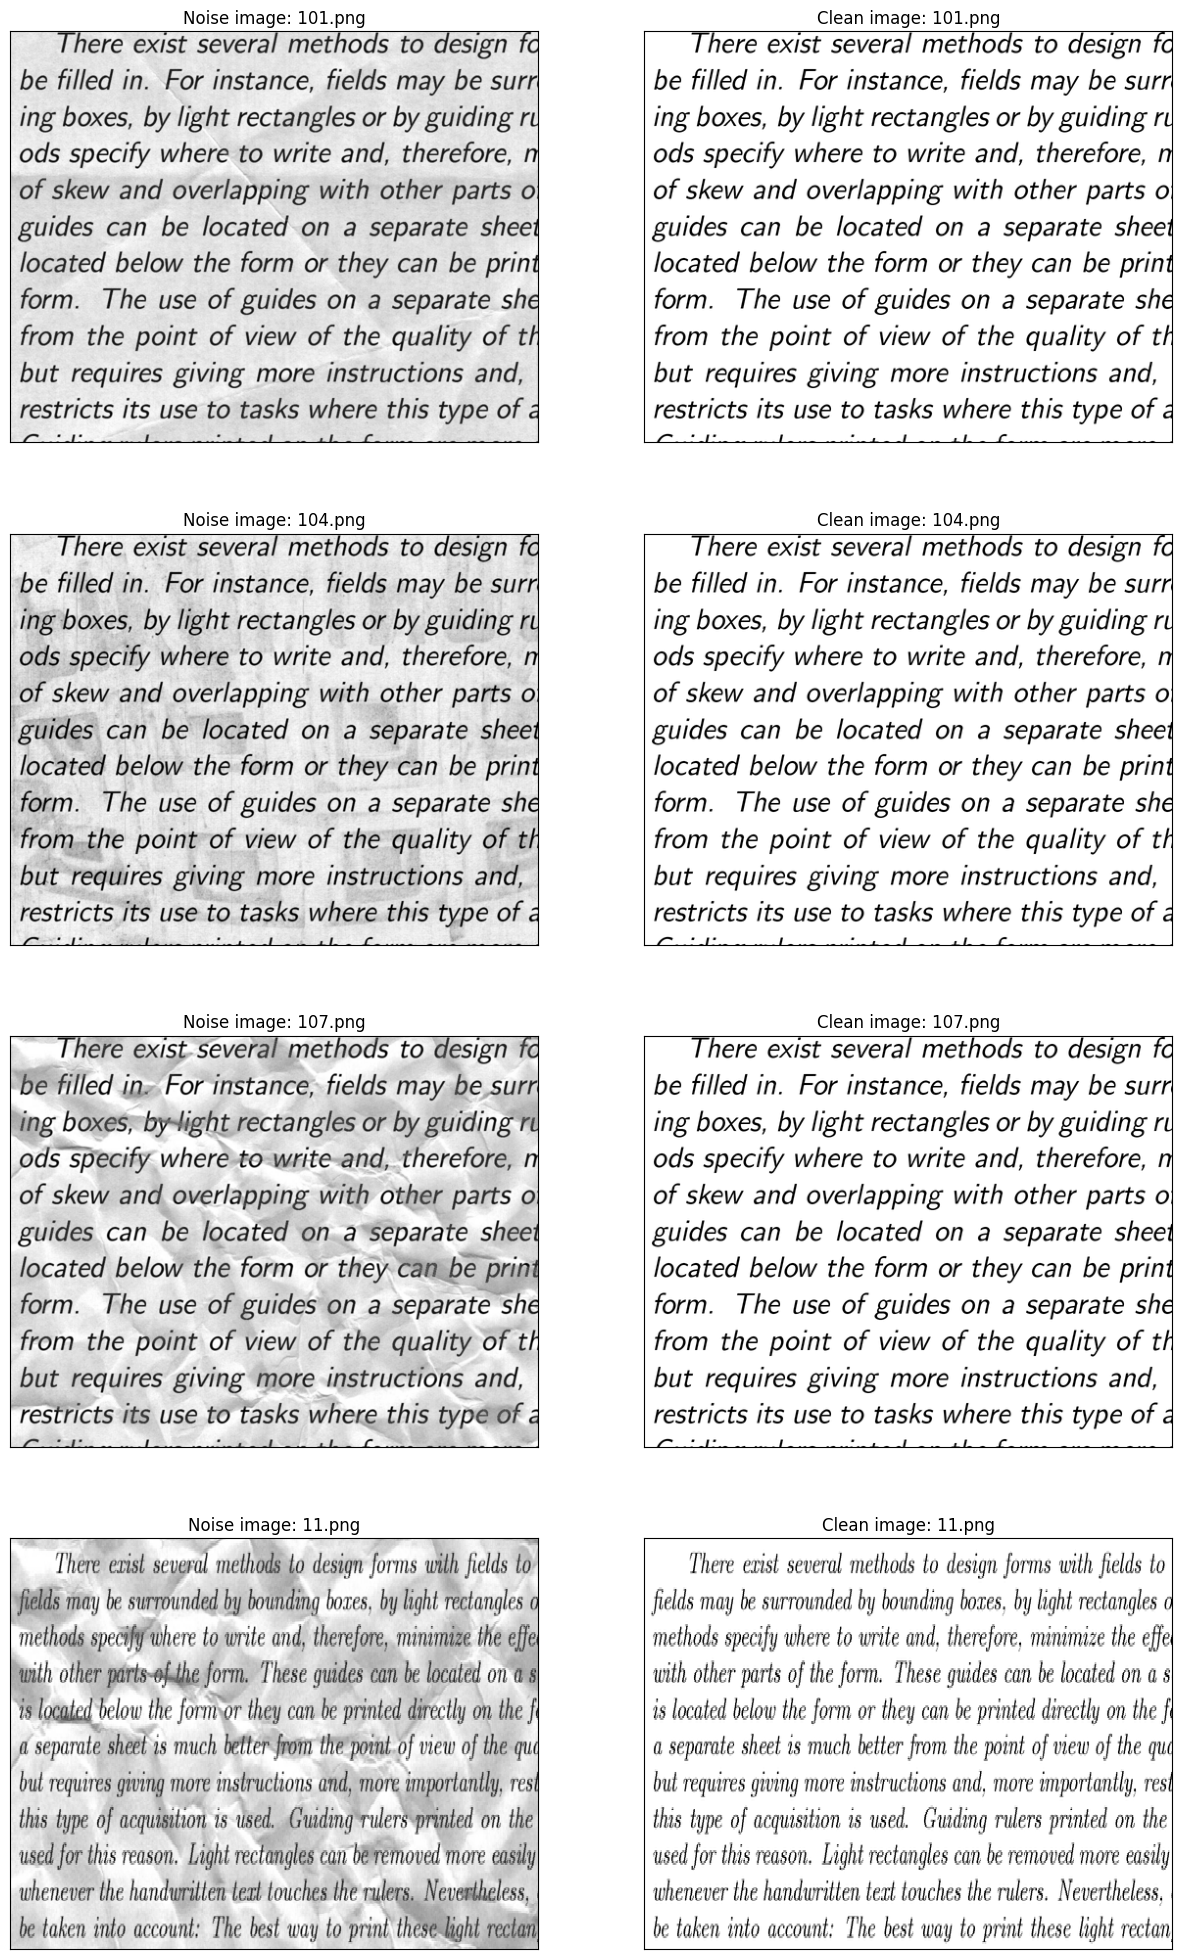

In [28]:
plt.figure(figsize=(15, 25))
for i in range(0, 8, 2):
  plt.subplot(4, 2, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train[i][:, :, 0], cmap='gray')
  plt.title('Noise image: {}'.format(train_img[i]))

  plt.subplot(4, 2, i + 2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_cleaned[i][:, :, 0], cmap='gray')
  plt.title('Clean image: {}'.format(train_img[i]))

## เตรียมข้อมูล Train และ Validate

In [29]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
X_train.shape, X_val.shape

((122, 420, 540, 1), (22, 420, 540, 1))

## สร้าง Model

In [30]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()

    self.encoder = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
        Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
        Dropout(0.4)
    ])

    self.decoder = Sequential([
        Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
callback = EarlyStopping(monitor='loss', patience=20)
history = autoencoder.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 20s 1s/step - loss: 0.5639 - val_loss: 0.3384
Epoch 2/100
8/8 [==============================] - 4s 528ms/step - loss: 0.3585 - val_loss: 0.3400
Epoch 3/100
8/8 [==============================] - 4s 524ms/step - loss: 0.3307 - val_loss: 0.3102
Epoch 4/100
8/8 [==============================] - 4s 522ms/step - loss: 0.3102 - val_loss: 0.2970
Epoch 5/100
8/8 [==============================] - 4s 536ms/step - loss: 0.2909 - val_loss: 0.2721
Epoch 6/100
8/8 [==============================] - 4s 533ms/step - loss: 0.2620 - val_loss: 0.2349
Epoch 7/100
8/8 [==============================] - 4s 532ms/step - loss: 0.2270 - val_loss: 0.2036
Epoch 8/100
8/8 [==============================] - 4s 538ms/step - loss: 0.2039 - val_loss: 0.1909
Epoch 9/100
8/8 [==============================] - 4s 544ms/step - loss: 0.1912 - val_loss: 0.1793
Epoch 10/100
8/8 [==============================] - 4s 545ms/step - loss: 0.1807 - val_loss: 0.1689
Epoch 11/10

In [31]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 210, 270, 64)      640       
                                                                 
 conv2d_4 (Conv2D)           (None, 105, 135, 128)     73856     
                                                                 
 dropout (Dropout)           (None, 105, 135, 128)     0         
                                                                 
Total params: 74,496
Trainable params: 74,496
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 210, 270, 128)    147584    
 ranspose)                                                       
                            

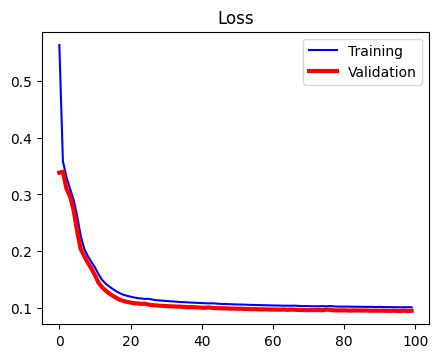

In [32]:
plt.figure(figsize=(5, 3.8))
plt.plot(history.history['loss'], color='b', label="Training")
plt.plot(history.history['val_loss'], 'r', lw=3, label="Validation")
plt.title('Loss')
plt.legend()
plt.show()

## ใช้งาน

5/5 [==============================] - 2s 477ms/step


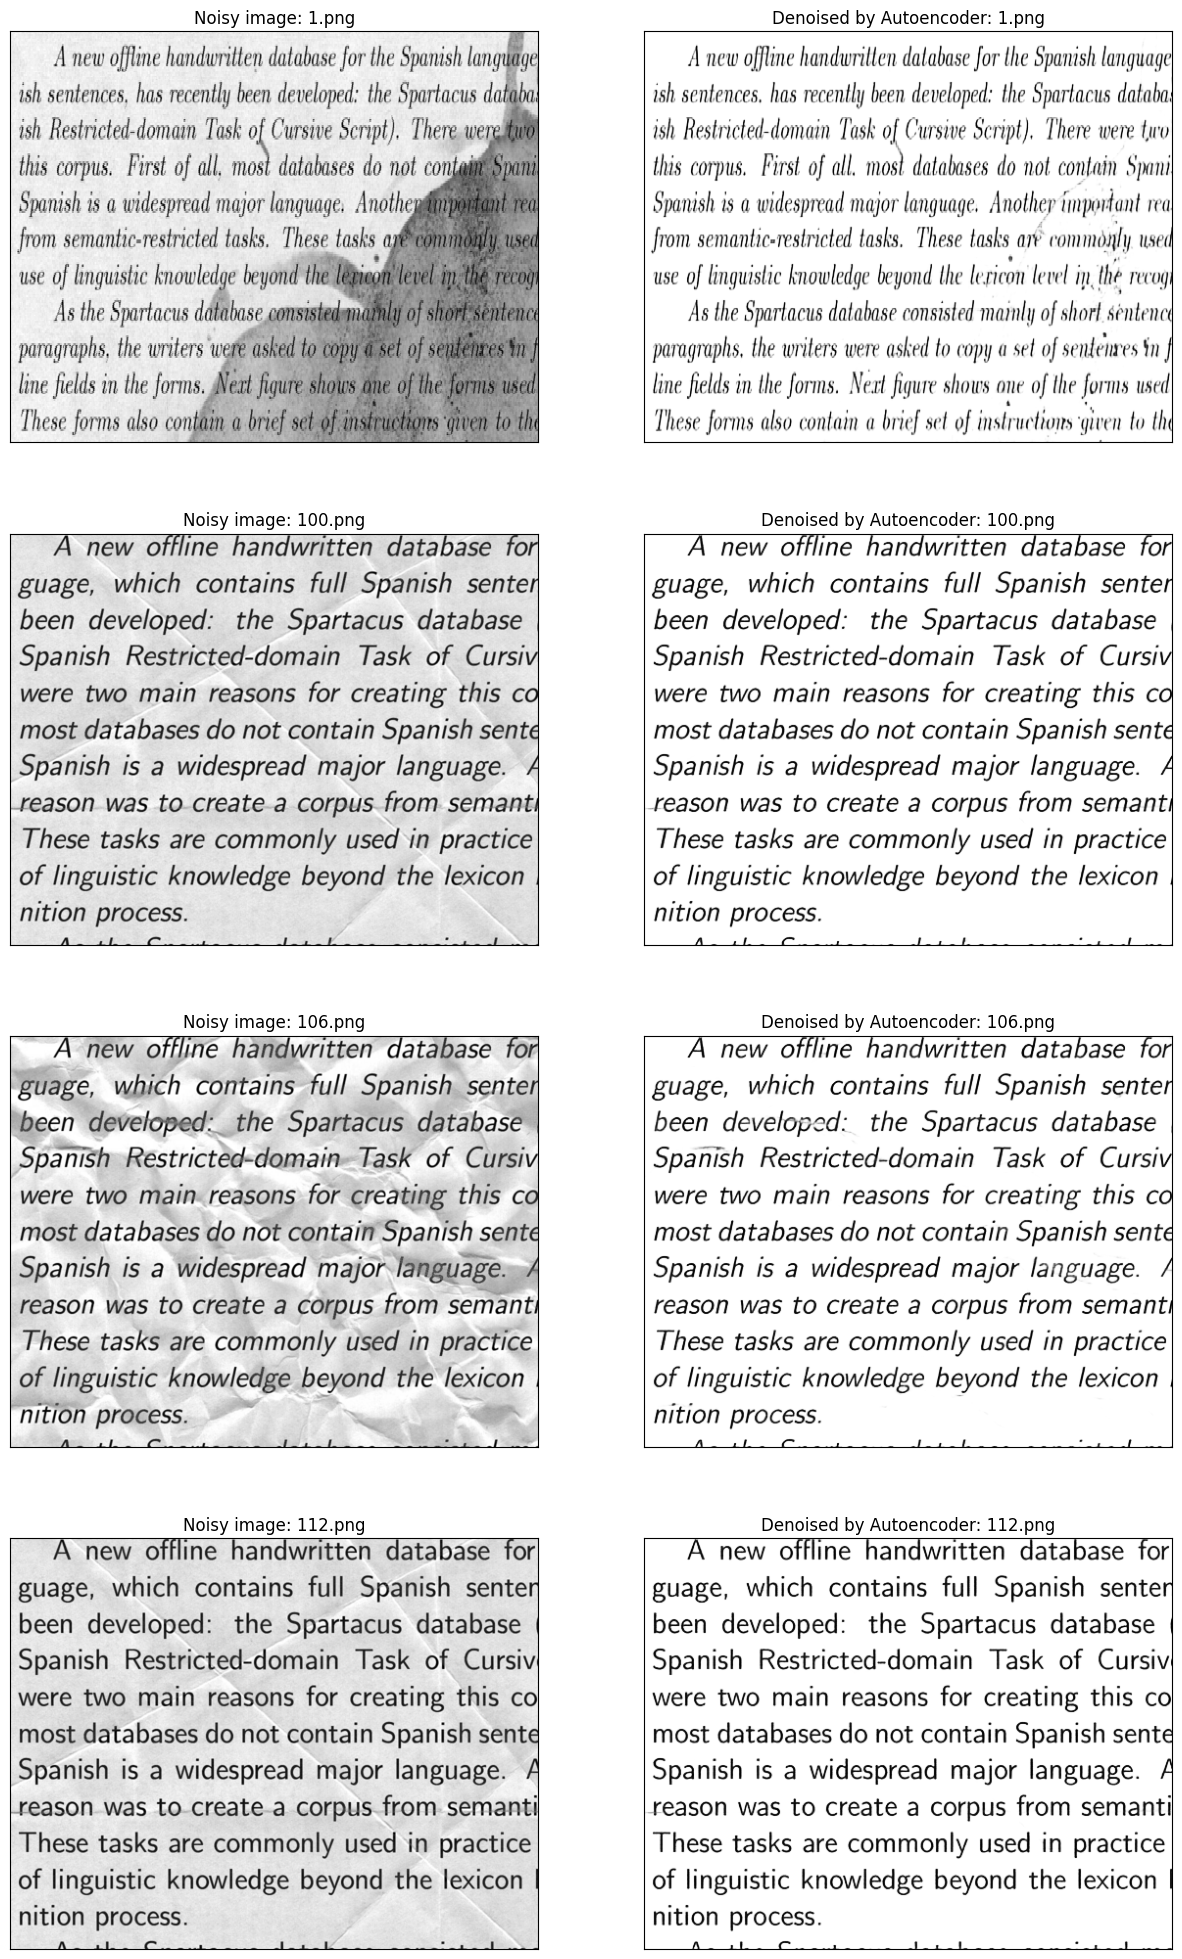

In [33]:
Y_pred = autoencoder.predict(X_test, batch_size=16)

plt.figure(figsize=(15, 25))
for i in range(0, 8, 2):
  plt.subplot(4, 2, i + 1)
  plt.title("Noisy image: {}".format(test_img[i]))
  plt.imshow(X_test[i][:, :, 0], cmap='gray')
  plt.xticks([]); plt.yticks([])

  plt.subplot(4, 2, i + 2)
  plt.title("Denoised by Autoencoder: {}".format(test_img[i]))
  plt.imshow(Y_pred[i][:, :, 0], cmap='gray')
  plt.xticks([]); plt.yticks([])
plt.show()